Modelle vergleichen über CV

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.width", 200)

# Führt CV durch und berechnet die Metriken
def repeated_k_fold(model, X, y, n_splits=5, n_repeats=10):
    rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    accuracy_train, accuracy_test = [], []
    f1, recall, roc_auc = [], [], []

    for train_index, test_index in rkf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        accuracy_train.append(accuracy_score(y_train, y_train_pred))
        accuracy_test.append(accuracy_score(y_test, y_test_pred))
        f1.append(f1_score(y_test, y_test_pred))
        recall.append(recall_score(y_test, y_test_pred))
        roc_auc.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

    return {
        "Train Accuracy": (np.mean(accuracy_train), np.std(accuracy_train)),
        "Test Accuracy": (np.mean(accuracy_test), np.std(accuracy_test)),
        "F1-Score_1": (np.mean(f1), np.std(f1)),
        "Recall_1": (np.mean(recall), np.std(recall)),
        "ROC-AUC_1": (np.mean(roc_auc), np.std(roc_auc)),
    }


# Pfad zur Datei
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML.xlsx"

try:
    df = pd.read_excel(file_path)

    # Zielvariable (y) und Features (X) extrahieren
    y = df['Verletzungsstatus']
    
    # Dummy-Variable "Geschlecht_weiblich" separieren
    if 'Geschlecht_weiblich' in df.columns:
        geschlecht_weiblich = df[['Geschlecht_weiblich']]
        X = df.drop(columns=['Verletzungsstatus', 'Geschlecht_weiblich'])
    else:
        X = df.drop(columns=['Verletzungsstatus'])
        geschlecht_weiblich = None  

    # Skalierung der Features (ohne "Geschlecht_weiblich")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Falls vorhanden, die Dummy-Variable wieder anhängen
    if geschlecht_weiblich is not None:
        X_scaled = np.hstack((X_scaled, geschlecht_weiblich.values))

    # Modelle definieren
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
        "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
        "SVC": SVC(probability=True, random_state=42),
        "k-Nearest Neighbors": KNeighborsClassifier(),
        "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42),
        "Gaussian Naive Bayes": GaussianNB(),
        "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
        "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
        "Bagging Classifier": BaggingClassifier(random_state=42),
        "Extra Trees": ExtraTreesClassifier(random_state=42),
    }

    results = []
    for model_name, model in models.items():
        print(f"Modell wird validiert: {model_name}")
        metrics = repeated_k_fold(model, X_scaled, y)  
        
        # Formatierung der Ergebnisse mit ±
        formatted_metrics = {
            "Model": model_name,
            "Train Accuracy": f"{metrics['Train Accuracy'][0]:.4f} ± {metrics['Train Accuracy'][1]:.4f}",
            "Test Accuracy": f"{metrics['Test Accuracy'][0]:.4f} ± {metrics['Test Accuracy'][1]:.4f}",
            "F1-Score_1": f"{metrics['F1-Score_1'][0]:.4f} ± {metrics['F1-Score_1'][1]:.4f}",
            "Recall_1": f"{metrics['Recall_1'][0]:.4f} ± {metrics['Recall_1'][1]:.4f}",
            "ROC-AUC_1": f"{metrics['ROC-AUC_1'][0]:.4f} ± {metrics['ROC-AUC_1'][1]:.4f}",
        }

        results.append(formatted_metrics)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="ROC-AUC_1", ascending=False)

    print("\nErgebnisse der Modelle:")
    print(results_df)


except FileNotFoundError:
    print("Die Datei wurde nicht gefunden. Bitte überprüfe den Pfad.")
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")


Mutual Information wird mit Korrelationsmatrix kombiniert und über Optuna-Optimierung werden die Variablen ausgewählt, die ROC-AUC optimieren. CV: split=5, repeats=10; r=0,8

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from IPython.display import display
from collections import Counter
optuna.logging.set_verbosity(optuna.logging.WARNING)


# Laden der Daten
def load_data(file_path):
    df = pd.read_excel(file_path)
    X = df.drop(columns=["Verletzungsstatus"])
    y = df["Verletzungsstatus"]
    return X, y

# Vorverarbeitung der Daten
def preprocess_data(X):
    dummy_var = X["Geschlecht_weiblich"]
    cols_to_scale = [col for col in X.columns if col != "Geschlecht_weiblich"]
    scaler = StandardScaler()
    X_scaled = X.copy()
    X_scaled[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
    X_scaled["Geschlecht_weiblich"] = dummy_var  
    return X_scaled

# Auswahl an nicht hochkorrelierten Features herstellen
def calculate_feature_selection(X_train, y_train, correlation_threshold=0.8):
    # Berechnungen für Feature Selektion
    correlation_matrix = X_train.corr().abs()
    mutual_info = mutual_info_classif(X_train, y_train)
    
    # ausgewählte Features
    selected_features = list(X_train.columns)  # Beginne mit allen Features
    
    # Iteriere über alle Feature-Paare
    for col in X_train.columns:
        if col in selected_features:
            # Suche nach anderen hochkorrelierten Features
            correlated_features = correlation_matrix[col].loc[correlation_matrix[col] > correlation_threshold].index.tolist()
            correlated_features.remove(col)  # Entferne das aktuelle Feature selbst
            
            if correlated_features:
                # Wenn es hochkorrelierte Features gibt, wähle das mit der höchsten Mutual Information
                for correlated_feature in correlated_features:
                    if mutual_info[X_train.columns.get_loc(col)] < mutual_info[X_train.columns.get_loc(correlated_feature)]:
                        # Entferne das Feature mit der geringeren Mutual Information
                        if col in selected_features:
                            selected_features.remove(col)
                    else:
                        # Entferne das Feature mit der geringeren Mutual Information
                        if correlated_feature in selected_features:
                            selected_features.remove(correlated_feature)
    
    return selected_features


# Optuna-Optimierung für äußere CV mit durchschnittlicher Anzahl an Features aus der inneren CV als Zielwert
def optimize_feature_selection(X_train, y_train, target_num_features):
    # Zuerst die nicht hochkorrelierten Features bestimmen
    candidate_features = calculate_feature_selection(X_train, y_train, correlation_threshold=0.8)
    candidate_features = sorted(candidate_features)
    # Stelle sicher, dass target_num_features nicht größer als die Anzahl der Kandidaten ist:
    target_num_features = min(target_num_features, len(candidate_features))
    
    def objective(trial):
        # Der Suchraum orientiert sich an target_num_features, aber es darf nicht mehr als die
        # vorhandenen Kandidatenfeatures ausgewählt werden.
        num_features = trial.suggest_int(
            "num_features",
            max(5, target_num_features-5),
            min(len(candidate_features), target_num_features+5)
        )
        
        # Falls num_features größer als die Anzahl der Kandidatenfeatures sein könnte, beschränke sie
        num_features = min(num_features, len(candidate_features))
        
        # Auswahl der ersten num_features aus dem Kandidatenpool
        X_train_optimized = X_train[candidate_features[:num_features]]
        
        model = LogisticRegression(max_iter=1000)
        score = cross_val_score(model, X_train_optimized, y_train, cv=5, scoring="roc_auc", n_jobs=-1).mean()
        return score
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, n_jobs=-1)
    return study.best_trial


# komplette innere CV mit Berechnung der duchschnittlichen Anzahl an Features als Ausgabe
def inner_cv_feature_selection(X_train, y_train):
    inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    best_num_features = []
    feature_counts = []  # Speichert die Anzahl der nicht hochkorrelierten Features pro Fold

    for inner_train_idx, inner_test_idx in inner_cv.split(X_train, y_train):
        X_inner_train, X_inner_test = X_train.iloc[inner_train_idx], X_train.iloc[inner_test_idx]
        y_inner_train, y_inner_test = y_train.iloc[inner_train_idx], y_train.iloc[inner_test_idx]

        # Berechne den Kandidatenpool
        candidate_features = calculate_feature_selection(X_inner_train, y_inner_train, correlation_threshold=0.8)
        candidate_features = sorted(candidate_features)
        
        # Speicher die Anzahl der übrig gebliebenen Features
        feature_counts.append(len(candidate_features))
        
        # Falls der Kandidatenpool leer ist, setze alle Features ein
        if len(candidate_features) == 0:
            candidate_features = list(X_inner_train.columns)
        
        def objective(trial):
            low_bound = 1
            high_bound = len(candidate_features)
            num_features = trial.suggest_int("num_features", low_bound, high_bound)
            X_selected = X_inner_train[candidate_features[:num_features]]

            model = LogisticRegression(max_iter=1000)
            score = cross_val_score(model, X_selected, y_inner_train, cv=5, scoring="roc_auc", n_jobs=-1).mean()
            return score

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=100, n_jobs=-1)
        best_num_features.append(study.best_trial.params["num_features"])
        
    # Berechnung von Median der besten Feature-Anzahl
    median_features = int(np.median(best_num_features))

    return median_features, feature_counts


def cross_validate(X, y):
    outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    
    # Listen zum Sammeln der Metriken
    train_accuracies = []
    test_accuracies = []
    f1_scores = []
    recall_scores = []
    precision_scores = []  # Neue Liste für Precision
    roc_auc_scores = []
    num_features = []
    selected_features_outer = []
    confusion_matrices = []  # Neue Liste für Konfusionsmatrizen
    
    all_feature_counts = []

    for outer_train_idx, outer_test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
        y_train, y_test = y.iloc[outer_train_idx], y.iloc[outer_test_idx]

        avg_selected_features, feature_counts_inner = inner_cv_feature_selection(X_train, y_train)
        all_feature_counts.extend(feature_counts_inner)
        
        candidate_features = calculate_feature_selection(X_train, y_train, correlation_threshold=0.8)
        candidate_features = sorted(candidate_features)
        trial = optimize_feature_selection(X_train[candidate_features], y_train, avg_selected_features)
        num_features_optimized = trial.params['num_features']
        
        selected_features_outer.append(candidate_features[:num_features_optimized])
        
        X_train_optimized = X_train[candidate_features[:num_features_optimized]]
        X_test_optimized = X_test[candidate_features[:num_features_optimized]]

        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_optimized, y_train)
        
        y_train_pred = model.predict(X_train_optimized)
        y_test_pred = model.predict(X_test_optimized)

        # Berechnungen der Metriken
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred)  # Neue Metrik
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_optimized)[:, 1])
        
        # Konfusionsmatrix berechnen
        conf_matrix = confusion_matrix(y_test, y_test_pred)
        confusion_matrices.append(conf_matrix)

        # Speichern der Metriken
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        f1_scores.append(f1)
        recall_scores.append(recall)
        precision_scores.append(precision)  # Neue Metrik speichern
        roc_auc_scores.append(roc_auc)
        num_features.append(num_features_optimized)
    
    # Durchschnittliche Konfusionsmatrix berechnen
    avg_confusion_matrix = np.mean(confusion_matrices, axis=0)
    std_confusion_matrix = np.std(confusion_matrices, axis=0)
    
    results_summary = {
        'Train Accuracy': np.mean(train_accuracies),
        'Train Accuracy Std': np.std(train_accuracies),
        'Test Accuracy': np.mean(test_accuracies),
        'Test Accuracy Std': np.std(test_accuracies),
        'F1-Score_1': np.mean(f1_scores),
        'F1-Score Std': np.std(f1_scores),
        'Recall_1': np.mean(recall_scores),
        'Recall Std': np.std(recall_scores),
        'Precision_1': np.mean(precision_scores),  # Neue Metrik
        'Precision Std': np.std(precision_scores),  # Neue Metrik
        'ROC-AUC_1': np.mean(roc_auc_scores),
        'ROC-AUC Std': np.std(roc_auc_scores),
        'Feature-Anzahl': np.mean(num_features),
        'Feature-Anzahl Std': np.std(num_features)
    }

    raw_metrics = {
        "Train Accuracies": train_accuracies,
        "Test Accuracies": test_accuracies,
        "F1 Scores": f1_scores,
        "Recall Scores": recall_scores,
        "Precision Scores": precision_scores,  # Neue Metrik
        "ROC-AUC Scores": roc_auc_scores,
        "Feature-Anzahlen": num_features
    }

    return results_summary, raw_metrics, selected_features_outer, all_feature_counts, (avg_confusion_matrix, std_confusion_matrix)


def compute_feature_usage(selected_features_outer):
    # Flache Liste aller ausgewählten Features aus den einzelnen Folds erstellen
    all_selected_features = [feature for fold in selected_features_outer for feature in fold]
    # Häufigkeiten zählen
    feature_usage = Counter(all_selected_features)
    # Filter nur Features, die mindestens einmal vorkamen (was per Definition immer der Fall ist)
    most_common_features = feature_usage.most_common()
    return most_common_features

def compute_feature_stats(all_feature_counts):
    # Berechnung der durchschnittlichen Anzahl der nicht hochkorrelierten Features
    mean_features = np.mean(all_feature_counts)
    std_features = np.std(all_feature_counts)
    
    # Rückgabe der berechneten Werte
    return mean_features, std_features


def display_results_summary(results_summary):
    # Formatierte Metriken mit ± Standardabweichung
    formatted_metrics = {
        "Gruppe": ["Total", "1 (Verletzte)"],
        "Train Accuracy": [
            f"{results_summary['Train Accuracy']*100:.2f} ± {results_summary['Train Accuracy Std']*100:.2f}",
            "-"
        ],
        "Test Accuracy": [
            f"{results_summary['Test Accuracy']*100:.2f} ± {results_summary['Test Accuracy Std']*100:.2f}",
            "-"
        ],
        "F1 Score": [
            "-",
            f"{results_summary['F1-Score_1']*100:.2f} ± {results_summary['F1-Score Std']*100:.2f}"
        ],
        "Recall": [
            "-",
            f"{results_summary['Recall_1']*100:.2f} ± {results_summary['Recall Std']*100:.2f}"
        ],
        "Precision": [  # Hinzugefügt
            "-",
            f"{results_summary['Precision_1']*100:.2f} ± {results_summary['Precision Std']*100:.2f}"
        ],
        "ROC-AUC": [
            f"{results_summary['ROC-AUC_1']*100:.2f} ± {results_summary['ROC-AUC Std']*100:.2f}",
            f"{results_summary['ROC-AUC_1']*100:.2f} ± {results_summary['ROC-AUC Std']*100:.2f}"
        ],
        "Anzahl-Features": [
            f"{results_summary['Feature-Anzahl']:.2f} ± {results_summary['Feature-Anzahl Std']:.2f}",
            "-"
        ]
    }

    # Erstellen des DataFrames
    df = pd.DataFrame(formatted_metrics)

    # Formatierung des DataFrames für HTML-Ausgabe
    styled_df = df.style.set_properties(**{"text-align": "center", "color": "black"}) \
                        .set_table_styles([{
                            "selector": "th", 
                            "props": [("font-size", "14px"), 
                                      ("background-color", "#f2f2f2"), 
                                      ("color", "black")]
                        }]) \
                        .set_caption("Durchschnittliche Evaluierungsmetriken über die äußere CV")

    display(styled_df)


def plot_raw_metrics(raw_metrics):
    # Erstellen eines DataFrames für die fünf Metriken
    metrics_df = pd.DataFrame({
        "Train Accuracy": raw_metrics["Train Accuracies"],
        "Test Accuracy": raw_metrics["Test Accuracies"],
        "F1 Score": raw_metrics["F1 Scores"],
        "Recall": raw_metrics["Recall Scores"],
        "Precision": raw_metrics["Precision Scores"], 
        "ROC-AUC": raw_metrics["ROC-AUC Scores"]
    })
    # Umwandlung in das Long-Format (tidy data)
    metrics_long = metrics_df.melt(var_name="Metrik", value_name="Wert")
    
    # Erstellen des Boxplots für die fünf Metriken
    plt.figure(figsize=(12, 8))
    sns.boxplot(x="Wert", y="Metrik", data=metrics_long)
    plt.xlabel("Score")
    plt.title("Verteilung der Evaluierungsmetriken über die äußere CV")
    plt.show()
    
    # Erstellen eines separaten DataFrames für die Feature-Anzahl
    features_df = pd.DataFrame({
        "Feature-Anzahl": raw_metrics["Feature-Anzahlen"]
    })
    
    # Erstellen eines separaten Boxplots für die Feature-Anzahl
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Feature-Anzahl", data=features_df)
    plt.xlabel("Feature-Anzahl")
    plt.title("Verteilung der Feature-Anzahlen über die äußere CV")
    plt.show()

def plot_confusion_matrix(avg_confusion_matrix, std_confusion_matrix):
    plt.figure(figsize=(8, 6))
    
    # Erstelle eine Matrix mit formatierten Strings (Durchschnitt ± Std)
    formatted_matrix = np.empty_like(avg_confusion_matrix, dtype=object)
    for i in range(avg_confusion_matrix.shape[0]):
        for j in range(avg_confusion_matrix.shape[1]):
            formatted_matrix[i,j] = f'{avg_confusion_matrix[i,j]:.2f}\n±{std_confusion_matrix[i,j]:.2f}'
    
    # Erstelle Heatmap
    sns.heatmap(avg_confusion_matrix, 
                annot=formatted_matrix, 
                fmt='', 
                cmap='Blues',
                cbar_kws={'label': 'Durchschnittliche Anzahl'})
    
    plt.title('Konfusionsmatrix (Durchschnitt ± Standardabweichung)')
    plt.xlabel('Vorhergesagte Klasse')
    plt.ylabel('Tatsächliche Klasse')
    
    plt.tight_layout()
    plt.show()

def print_feature_importance_table(most_common_features):
    # Erstelle ein DataFrame aus dem Counter
    df_features = pd.DataFrame(most_common_features, columns=["Feature", "Häufigkeit"])
    # Formatierung der Tabelle
    styled_df = df_features.style.set_properties(**{"text-align": "center", "color": "black"}) \
                         .set_table_styles([{"selector": "th", 
                                              "props": [("font-size", "14px"), 
                                                        ("background-color", "#f2f2f2"), 
                                                        ("color", "black")]}]) \
                         .set_caption("Häufigste in der finalen Feature-Auswahl verwendete Features")
    display(styled_df)
    
def main():
    file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_neu.xlsx"
    X, y = load_data(file_path)
    X_scaled = preprocess_data(X)
    
    results_summary, raw_metrics, selected_features_outer, all_feature_counts, confusion_matrices = cross_validate(X_scaled, y)
    
    print("\nErgebnisse der äußeren Cross-Validation (aggregiert):")
    display_results_summary(results_summary)
    
    print("\nVerteilung der Evaluierungsmetriken (Boxplot):")
    plot_raw_metrics(raw_metrics)
    
    print("\nKonfusionsmatrix:")
    plot_confusion_matrix(confusion_matrices[0], confusion_matrices[1])
    
    most_common_features = compute_feature_usage(selected_features_outer)
    print("\nHäufigste verwendete Features:")
    print_feature_importance_table(most_common_features)
    
    mean_features, std_features = compute_feature_stats(all_feature_counts)
    print(f"\nDurchschnittliche Anzahl nicht hochkorrelierter Features über alle inneren CVs: {mean_features:.2f} ± {std_features:.2f}")
    
if __name__ == "__main__":
    main()


Evaluierungsmetriken der Modelle im Vergleich bei reduzierter Variablenanzahl

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.width", 200)

# Führt CV durch und berechnet die Metriken
def repeated_k_fold(model, X, y, n_splits=5, n_repeats=10):
    rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    accuracy_train, accuracy_test = [], []
    f1, recall, roc_auc = [], [], []

    for train_index, test_index in rkf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        accuracy_train.append(accuracy_score(y_train, y_train_pred))
        accuracy_test.append(accuracy_score(y_test, y_test_pred))
        f1.append(f1_score(y_test, y_test_pred))
        recall.append(recall_score(y_test, y_test_pred))
        roc_auc.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

    return {
        "Train Accuracy": (np.mean(accuracy_train), np.std(accuracy_train)),
        "Test Accuracy": (np.mean(accuracy_test), np.std(accuracy_test)),
        "F1-Score_1": (np.mean(f1), np.std(f1)),
        "Recall_1": (np.mean(recall), np.std(recall)),
        "ROC-AUC_1": (np.mean(roc_auc), np.std(roc_auc)),
    }


# Pfad zur Datei
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_mutualinf_korr.xlsx"

try:
    df = pd.read_excel(file_path)

    # Zielvariable (y) und Features (X) extrahieren
    y = df['Verletzungsstatus']
    
    # Dummy-Variable "Geschlecht_weiblich" separieren
    if 'Geschlecht_weiblich' in df.columns:
        geschlecht_weiblich = df[['Geschlecht_weiblich']]
        X = df.drop(columns=['Verletzungsstatus', 'Geschlecht_weiblich'])
    else:
        X = df.drop(columns=['Verletzungsstatus'])
        geschlecht_weiblich = None  

    # Skalierung der Features (ohne "Geschlecht_weiblich")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Falls vorhanden, die Dummy-Variable wieder anhängen
    if geschlecht_weiblich is not None:
        X_scaled = np.hstack((X_scaled, geschlecht_weiblich.values))

    # Modelle definieren
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
        "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
        "SVC": SVC(probability=True, random_state=42),
        "k-Nearest Neighbors": KNeighborsClassifier(),
        "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42),
        "Gaussian Naive Bayes": GaussianNB(),
        "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
        "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
        "Bagging Classifier": BaggingClassifier(random_state=42),
        "Extra Trees": ExtraTreesClassifier(random_state=42),
    }

    results = []
    for model_name, model in models.items():
        print(f"Modell wird validiert: {model_name}")
        metrics = repeated_k_fold(model, X_scaled, y)  
        
        # Formatierung der Ergebnisse mit ±
        formatted_metrics = {
            "Model": model_name,
            "Train Accuracy": f"{metrics['Train Accuracy'][0]:.4f} ± {metrics['Train Accuracy'][1]:.4f}",
            "Test Accuracy": f"{metrics['Test Accuracy'][0]:.4f} ± {metrics['Test Accuracy'][1]:.4f}",
            "F1-Score_1": f"{metrics['F1-Score_1'][0]:.4f} ± {metrics['F1-Score_1'][1]:.4f}",
            "Recall_1": f"{metrics['Recall_1'][0]:.4f} ± {metrics['Recall_1'][1]:.4f}",
            "ROC-AUC_1": f"{metrics['ROC-AUC_1'][0]:.4f} ± {metrics['ROC-AUC_1'][1]:.4f}",
        }

        results.append(formatted_metrics)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="ROC-AUC_1", ascending=False)

    print("\nErgebnisse der Modelle:")
    print(results_df)


except FileNotFoundError:
    print("Die Datei wurde nicht gefunden. Bitte überprüfe den Pfad.")
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")
    


Beispieldatensatz erzeugen und vorverarbeiten

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Originaldaten laden
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_neu.xlsx"
df_original = pd.read_excel(file_path)
print("Header:")
print(df_original.head())

# Aufteilen in Features und Zielvariable
X_original = df_original.drop(columns=["Verletzungsstatus"])
y_original = df_original["Verletzungsstatus"]

# Vorverarbeitung: StandardScaler auf alle numerischen Features außer "Geschlecht_weiblich"
def preprocess_data(X):
    dummy_var = X["Geschlecht_weiblich"]
    cols_to_scale = [col for col in X.columns if col != "Geschlecht_weiblich"]
    scaler = StandardScaler()
    X_scaled = X.copy()
    X_scaled[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
    X_scaled["Geschlecht_weiblich"] = dummy_var  
    return X_scaled

X_preprocessed = preprocess_data(X_original)
print("\nVorverarbeiteter Datensatz:")
print(X_preprocessed.head())


Header:
   Verletzungsstatus  Geschlecht_weiblich  CMJ_Jump Height flighttime  CMJ_Net Impulse  CMJ_Vertical Takeoff velocity  \
0                  1                    1                      22.961         2.153492                       0.032683   
1                  1                    0                      39.377         2.692762                       0.042159   
2                  1                    0                      36.429         2.587946                       0.027645   
3                  1                    0                      36.080         2.570528                       0.036000   
4                  1                    1                      20.183         2.023152                       0.029576   

   CMJ_Jump Height impulse  CMJ_Rel. peak loading force  INV_CMJ_uni_Rel. peak loading force   \
0                 0.342905                        2.299                                 0.995   
1                 0.570762                        2.075                

Datenaugmentation-Ansatz

In [33]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform


def perform_clustering(X_sub, max_clusters=4):
    """
    Führt eine Clusteranalyse auf den numerischen Parametern (außer den
    Gruppierungsvariablen "Verletzungsstatus" und "Geschlecht_weiblich")
    durch und teilt diese in max_clusters Gruppen ein.
    """
    # Wähle alle numerischen Spalten außer "Verletzungsstatus" und "Geschlecht_weiblich"
    cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
    X_num = X_sub[cols]
    
    # Berechne die Korrelationsmatrix und transformiere sie in eine Distanzmatrix
    corr = X_num.corr().abs()
    dist = np.clip(1 - corr, a_min=0, a_max=None)  # Clippe negative Werte auf 0
    
    # Konvertiere die Distanzmatrix in ein 1D-Array (upper triangular)
    dists = squareform(dist.values)
    
    # Hierarchische Clusteranalyse (z. B. mit der Ward-Methode)
    Z = linkage(dists, method='ward')
    
    # Führe fcluster aus, um die Spalten in max_clusters Cluster zu unterteilen
    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
    
    # Ordne den Spalten Clusterlabels zu
    clusters = {}
    for col, label in zip(cols, cluster_labels):
        clusters.setdefault(label, []).append(col)
    return clusters


def augment_subgroup(X_sub, clusters, p_augment=0.7):
    """
    Augmentiert die Daten in X_sub (einen DataFrame für eine Subgruppe)
    für alle in clusters definierten Parametergruppen.
    
    Für jede Zeile und für jede Cluster-Gruppe wird mit Wahrscheinlichkeit p_augment
    ein neuer Wert gezogen – ansonsten wird der Originalwert beibehalten.
    Dabei werden für jede Parametergruppe der Mittelwertvektor und die Kovarianzmatrix
    des gesamten Subdatensatzes berechnet.
    
    Rückgabe: DataFrame mit augmentierten Zeilen (1 augmentiertes Sample pro Originalzeile)
    """
    augmented_rows = []
    
    # Für jede Cluster-Gruppe: Berechne Mittelwert und Kovarianzmatrix
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        # Falls nur ein Feature im Cluster ist, gibt np.cov einen Skalar zurück.
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    
    # Gehe jede Zeile (Originaldatensatz) durch
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        # Für jede Cluster-Gruppe stochastisch augmentieren
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                # Ziehe einen neuen Vektor aus der multivariaten Normalverteilung
                new_values = np.random.multivariate_normal(mu, cov)
                # Überschreibe nur die Werte in den entsprechenden Spalten
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    
    augmented_df = pd.DataFrame(augmented_rows)
    
    # Sicherstellen, dass Gruppierungsvariablen den richtigen Datentyp behalten:
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    
    return augmented_df


# ----------------------------------------------------------------
# Funktion: Stratifikation und Augmentation der Trainingsdaten
# ----------------------------------------------------------------
def augment_training_data(X_train, y_train, max_clusters=4, p_augment=0.7, num_new_samples=1):
    """
    Führt zuerst eine Stratifikation des Trainingsdatensatzes nach "Verletzungsstatus"
    und "Geschlecht_weiblich" durch und wendet dann in jeder Subgruppe:
      - eine Clusteranalyse (auf alle übrigen numerischen Features)
      - die Augmentation (Ziehung neuer Samples aus multivariater Normalverteilung)
    an.
    
    num_new_samples gibt an, wie viele augmentierte Samples pro Originalzeile generiert werden.
    """
    # Kombiniere X_train und y_train, damit wir gruppieren können
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    df_train.reset_index(drop=True, inplace=True)
    
    # Stratifikation: Erstelle eine Gruppierung nach (Verletzungsstatus, Geschlecht_weiblich)
    augmented_groups = []
    for key, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"]):
        group_df = group_df.reset_index(drop=True)
        # Führe Clusteranalyse auf dieser Subgruppe durch
        clusters = perform_clustering(group_df, max_clusters=max_clusters)
        # Erzeuge für diese Subgruppe num_new_samples augmentierte Samples pro Zeile
        aug_list = []
        for _ in range(num_new_samples):
            aug = augment_subgroup(group_df, clusters, p_augment=p_augment)
            aug_list.append(aug)
        aug_group = pd.concat(aug_list, axis=0)
        augmented_groups.append(aug_group)
    
    # Vereinige alle augmentierten Subgruppen
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    
    # Trenne Zielvariable und Features (hier war "Verletzungsstatus" in df_train enthalten)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    
    return X_aug, y_aug

# ----------------------------------------------------------------
# Beispiel für die Integration in den Trainingssplit (innerer CV)
# ----------------------------------------------------------------
def inner_cv_with_augmentation(X_train, y_train):
    """
    Führt eine innere Cross-Validation durch, wobei in jedem Fold
    vor der Hyperparameter-Optimierung die Trainingsdaten augmentiert werden.
    """
    from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
    from sklearn.linear_model import LogisticRegression
    
    inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)  # Beispielhaft mit weniger Wiederholungen
    scores = []
    
    for train_idx, test_idx in inner_cv.split(X_train, y_train):
        X_inner_train, X_inner_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_inner_train, y_inner_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        # Augmentation auf den inneren Trainingsdaten durchführen:
        X_inner_train_aug, y_inner_train_aug = augment_training_data(X_inner_train, y_inner_train,
                                                                    max_clusters=4, p_augment=0.7, num_new_samples=3)
        # Beispiel: Modelltraining mit den augmentierten Trainingsdaten
        model = LogisticRegression(max_iter=1000)
       
        score = cross_val_score(model, X_inner_train_aug, y_inner_train_aug, cv=3, scoring="roc_auc", n_jobs=-1).mean()
        scores.append(score)
    
    print("Durchschnittliche Augmentations-basierte innere CV-ROC-AUC:", np.mean(scores))
    return np.mean(scores)


Test: perform_clustering

In [11]:
# Test: perform_clustering
print("=== Test: perform_clustering ===")
# Verwende den vorverarbeiteten Datensatz, aber hier kannst du auch einen kleineren Test-Datensatz nutzen:
clusters = perform_clustering(pd.concat([X_preprocessed, y_original], axis=1), max_clusters=4)
print("Ermittelte Cluster (übersichtlich):")
for cluster_label in sorted(clusters.keys()):
    features_in_cluster = clusters[cluster_label]
    print(f"Cluster {cluster_label} (n = {len(features_in_cluster)}):")
    print(", ".join(features_in_cluster))
    print("")  # Leerzeile für bessere Lesbarkeit


=== Test: perform_clustering ===
Ermittelte Cluster (übersichtlich):
Cluster 1 (n = 25):
CMJ_KAI ecc, CMJ_KAI con, CMJ_Landing KAI ecc, INV_CMJ_uni_Vertical Stiffness-Mittelwert [kN/m], INV_CMJ_uni_Braking Duration-Mittelwert [s], INV_CMJ_uni_Durchschnittliche Bremsgeschwindigkeit-Mittelwert [m/s], UNINV_CMJ_uni_Vertical Stiffness-Mittelwert [kN/m], UNINV_CMJ_uni_Braking Duration-Mittelwert [s], UNINV_CMJ_uni_Durchschnittliche Bremsgeschwindigkeit-Mittelwert [m/s], ISO_Drehmoment_Seitenunterschied Extension absolut, ISO_Drehmoment_Seitenunterschied Extension relativ, ISO_Drehmoment_Seitenunterschied Flexion absolut, ISO_Drehmoment_Seitenunterschied Flexion relativ, INV_ISO_Drehmoment_Verhaeltnis Flexion Extension , UNINV_ISO_Drehmoment_Verhaeltnis Flexion Extension , INV_ISO_Drehmoment_Unterschied Extension Flexion, UNINV_ISO_Drehmoment_Unterschied Extension Flexion , ISO_Arbeit_Seitenunterschied Extension absolut, ISO_Arbeit_Seitenunterschied Extension relativ, ISO_Arbeit_Seitenunters

Test: augment_subgroup

In [21]:
# Test: augment_subgroup
print("=== Test: augment_subgroup ===")
# Wähle eine Subgruppe aus dem gesamten Datensatz (als DataFrame inklusive Zielvariable)
subgroup = pd.concat([X_preprocessed, y_original], axis=1)
subgroup = subgroup[(subgroup["Verletzungsstatus"] == 0) & (subgroup["Geschlecht_weiblich"] == 0)]
print("Originale Subgruppe:")
print(subgroup.head())


# Führe Clusteranalyse auf dieser Subgruppe durch
clusters_sub = perform_clustering(subgroup, max_clusters=4)
print("\nCluster der Subgruppe:")
for cluster_label in sorted(clusters_sub.keys()):
    features_in_cluster = clusters_sub[cluster_label]
    print(f"Cluster {cluster_label} (n = {len(features_in_cluster)}):")
    print(", ".join(features_in_cluster))
    print("")  # Leerzeile für bessere Lesbarkeit


# Augmentiere die Subgruppe; setze p_augment auf 1.0 zum Testen
augmented_subgroup = augment_subgroup(subgroup, clusters_sub, p_augment=1.0)
print("\nAugmentierte Subgruppe:")
print(augmented_subgroup.head())

augmented_subgroup_partial = augment_subgroup(subgroup, clusters_sub, p_augment=0.7)
print("\nTeilweise augementierte Subgruppe:")
print(augmented_subgroup_partial.head())


print("Mittelwerte vorher:")
print(subgroup.mean())

print("\nMittelwerte nach Augmentation:")
print(augmented_subgroup.mean())



=== Test: augment_subgroup ===
Originale Subgruppe:
    Geschlecht_weiblich  CMJ_Jump Height flighttime  CMJ_Net Impulse  CMJ_Vertical Takeoff velocity  \
65                    0                   -0.703646        -0.322461                      -1.712610   
66                    0                   -0.185729        -0.140939                      -1.280145   
70                    0                   -0.822207        -2.547662                      -0.978520   
71                    0                    0.771316         0.193396                      -0.809763   
72                    0                    0.335838         0.959571                       0.176386   

    CMJ_Jump Height impulse  CMJ_Rel. peak loading force  INV_CMJ_uni_Rel. peak loading force   \
65                -1.454993                    -1.576288                             -0.461497   
66                -1.002516                     0.824683                              1.126182   
70                -1.100347        

Test: augment_training_data

=== Test: augment_training_data mit num_new_samples=3 ===
Shape des Originaldatensatzes: (113, 113)
Shape des augmentierten Datensatzes (num_new_samples=3): (339, 113)

Deskriptive Statistik - Original:
       Geschlecht_weiblich  CMJ_Jump Height flighttime  CMJ_Net Impulse  CMJ_Vertical Takeoff velocity  \
count           113.000000                1.130000e+02     1.130000e+02                   1.130000e+02   
mean              0.362832                9.272327e-16     5.936746e-16                  -8.272635e-16   
std               0.482959                1.004454e+00     1.004454e+00                   1.004454e+00   
min               0.000000               -2.156582e+00    -2.547662e+00                  -2.343086e+00   
25%               0.000000               -7.534867e-01    -7.492653e-01                  -6.281496e-01   
50%               0.000000               -1.379021e-01    -1.249907e-02                  -1.828617e-01   
75%               1.000000                6.201568e-01 

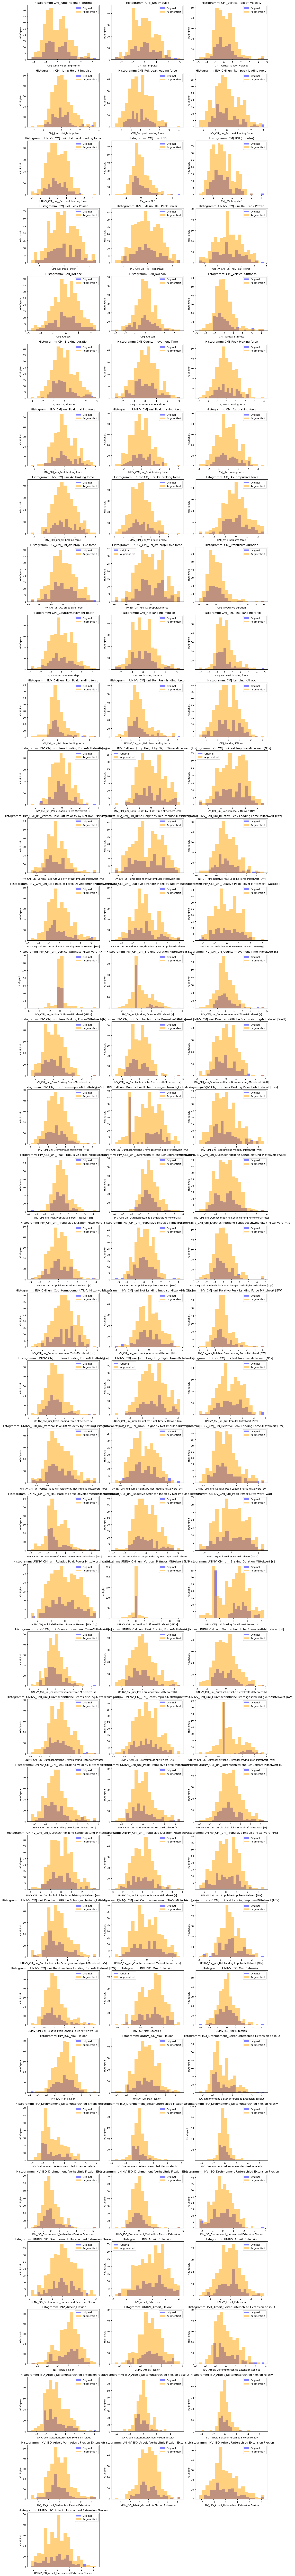

In [27]:


# Test: augment_training_data mit erhöhter num_new_samples
print("=== Test: augment_training_data mit num_new_samples=3 ===")
aug_X2, aug_y2 = augment_training_data(X_preprocessed, y_original, max_clusters=4, p_augment=0.7, num_new_samples=3)
print("Shape des Originaldatensatzes:", X_preprocessed.shape)
print("Shape des augmentierten Datensatzes (num_new_samples=3):", aug_X2.shape)

# Vergleich der deskriptiven Statistik
print("\nDeskriptive Statistik - Original:")
print(X_preprocessed.describe())

print("\nDeskriptive Statistik - Augmentiert (num_new_samples=3):")
print(aug_X2.describe())

import matplotlib.pyplot as plt
import math

# Verwende alle numerischen Variablen außer "Geschlecht_weiblich"
features = [col for col in X_preprocessed.columns if col not in ["Geschlecht_weiblich"]]

num_features = len(features)
cols = 3  # Anzahl der Spalten im Plot-Raster
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  # Einfacheres Iterieren über alle Achsen

for i, feature in enumerate(features):
    ax = axes[i]
    ax.hist(X_preprocessed[feature], bins=20, alpha=0.5, label='Original', color='blue')
    ax.hist(aug_X2[feature], bins=20, alpha=0.5, label='Augmentiert', color='orange')
    ax.set_xlabel(feature)
    ax.set_ylabel('Häufigkeit')
    ax.set_title(f"Histogramm: {feature}")
    ax.legend()

# Falls es ungenutzte Achsen gibt, diese entfernen:
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



Test: inner_cv_with_augmentation

In [35]:

# Funktion: innere CV ohne Augmentation
def inner_cv_without_augmentation(X_train, y_train):
    from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
    from sklearn.linear_model import LogisticRegression
    
    inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = []
    
    for train_idx, test_idx in inner_cv.split(X_train, y_train):
        X_inner_train, X_inner_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_inner_train, y_inner_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        model = LogisticRegression(max_iter=1000)
        score = cross_val_score(model, X_inner_train, y_inner_train, cv=3, scoring="roc_auc", n_jobs=-1).mean()
        scores.append(score)
    
    avg_score = np.mean(scores)
    
    return avg_score

# Vergleich beider Ansätze:
print("=== Vergleich: Innere CV ohne vs. mit Augmentation ===")
score_without = inner_cv_without_augmentation(X_preprocessed, y_original)
score_with = inner_cv_with_augmentation(X_preprocessed, y_original)

print("\nZusammenfassung der Ergebnisse:")
print("ROC-AUC ohne Augmentation:", score_without)
print("ROC-AUC mit Augmentation:", score_with)
print("Differenz:", score_with - score_without)

=== Vergleich: Innere CV ohne vs. mit Augmentation ===
Durchschnittliche Augmentations-basierte innere CV-ROC-AUC: 0.9743067571589225

Zusammenfassung der Ergebnisse:
ROC-AUC ohne Augmentation: 0.9260207929325578
ROC-AUC mit Augmentation: 0.9743067571589225
Differenz: 0.048285964226364664


In [ ]:
!git add 